In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_log_error, r2_score, explained_variance_score

In [3]:
directorio_base = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # Subir dos directorios
directorio_pkl = os.path.join(directorio_base, "src", "00.data", "clustering")

# Obtener todos los archivos .pkl en el directorio de preprocesado
archivos_pkl = [f for f in os.listdir(directorio_pkl) if f.startswith("df_clustering_") and f.endswith(".pkl")]

# Si no se encuentran archivos .pkl, mostramos un mensaje
if not archivos_pkl:
    print("❌ No se encontraron archivos .pkl en el directorio.")
else:
    df_lista = []

    # Cargar todos los archivos .pkl
    for archivo in archivos_pkl:
        ruta_archivo = os.path.join(directorio_pkl, archivo)
        try:
            with open(ruta_archivo, "rb") as f:
                df_lista.append(pickle.load(f))
                print(f"✅ Archivo cargado correctamente: {archivo}")
        except FileNotFoundError:
            print(f"❌ No se encontró el archivo: {archivo}")
        except Exception as e:
            print(f"❌ Error al cargar {archivo}: {e}")

    # Concatenar todos los DataFrames en uno solo
    if df_lista:
        df = pd.concat(df_lista, ignore_index=True)
        print(f"✅ DataFrame final con {df.shape[0]} filas y {df.shape[1]} columnas")
    else:
        print("❌ No se cargaron DataFrames.")

✅ Archivo cargado correctamente: df_clustering_1.pkl
✅ Archivo cargado correctamente: df_clustering_2.pkl
✅ Archivo cargado correctamente: df_clustering_3.pkl
✅ DataFrame final con 207137 filas y 10 columnas


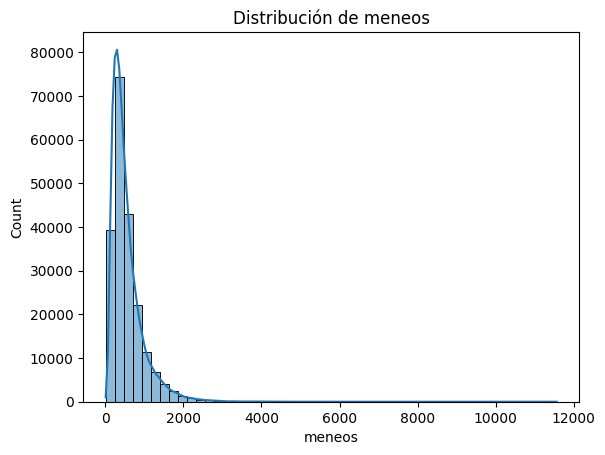

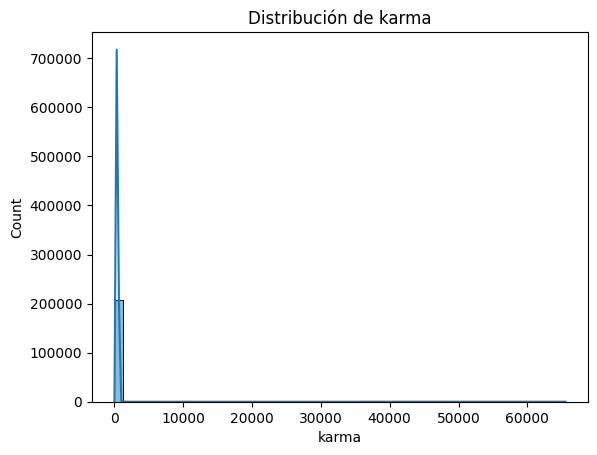

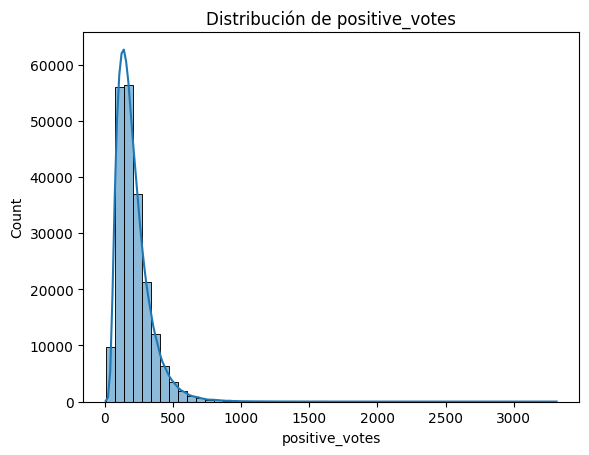

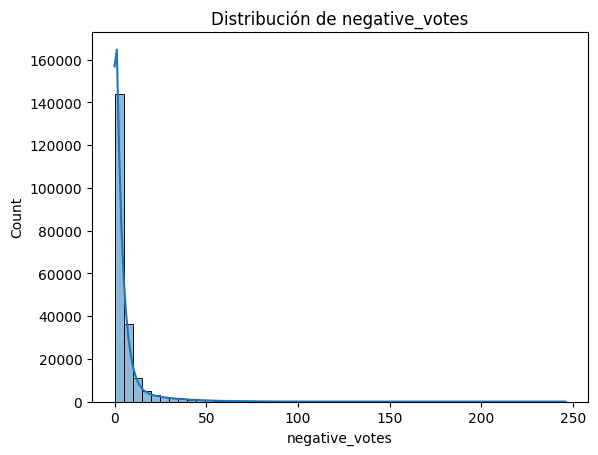

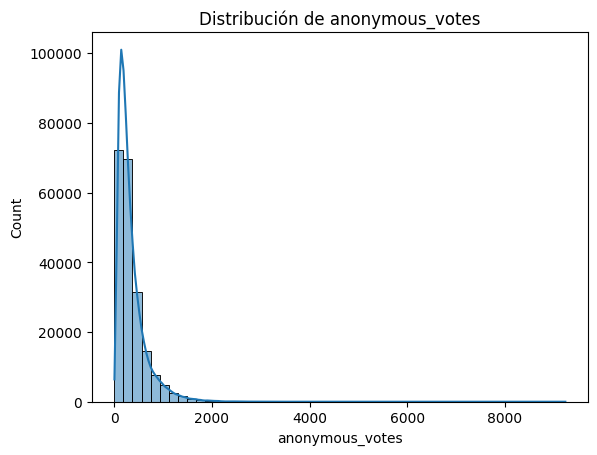

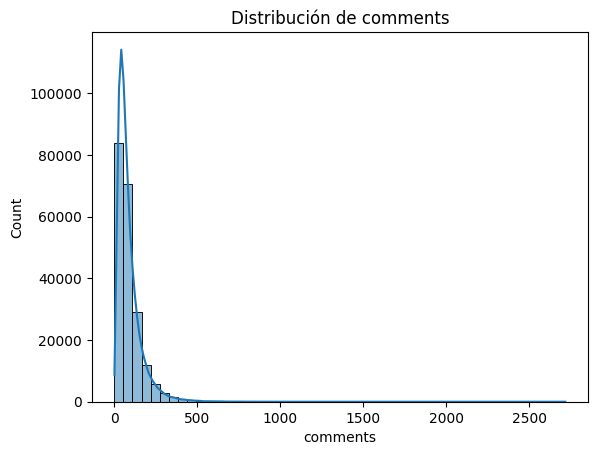

In [4]:
# Gráficoss para ver la distribución de variables numéricas y saber si aplicar nplog1
for col in ['meneos', 'karma', 'positive_votes', 'negative_votes', 'anonymous_votes', 'comments']:
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

In [5]:
def remove_outliers_tukey(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    df_no_outliers = df[~((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_no_outliers

In [6]:
def train_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = np.expm1(np.maximum(y_pred, 0))
    y_test = np.expm1(y_test)
    
    metrics = {
        'Model': model_name,
        'Median AE': median_absolute_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSLE': mean_squared_log_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
        'Explained Variance': explained_variance_score(y_test, y_pred)
    }
    return metrics, model

Procesando cluster 0...
(162976, 8)


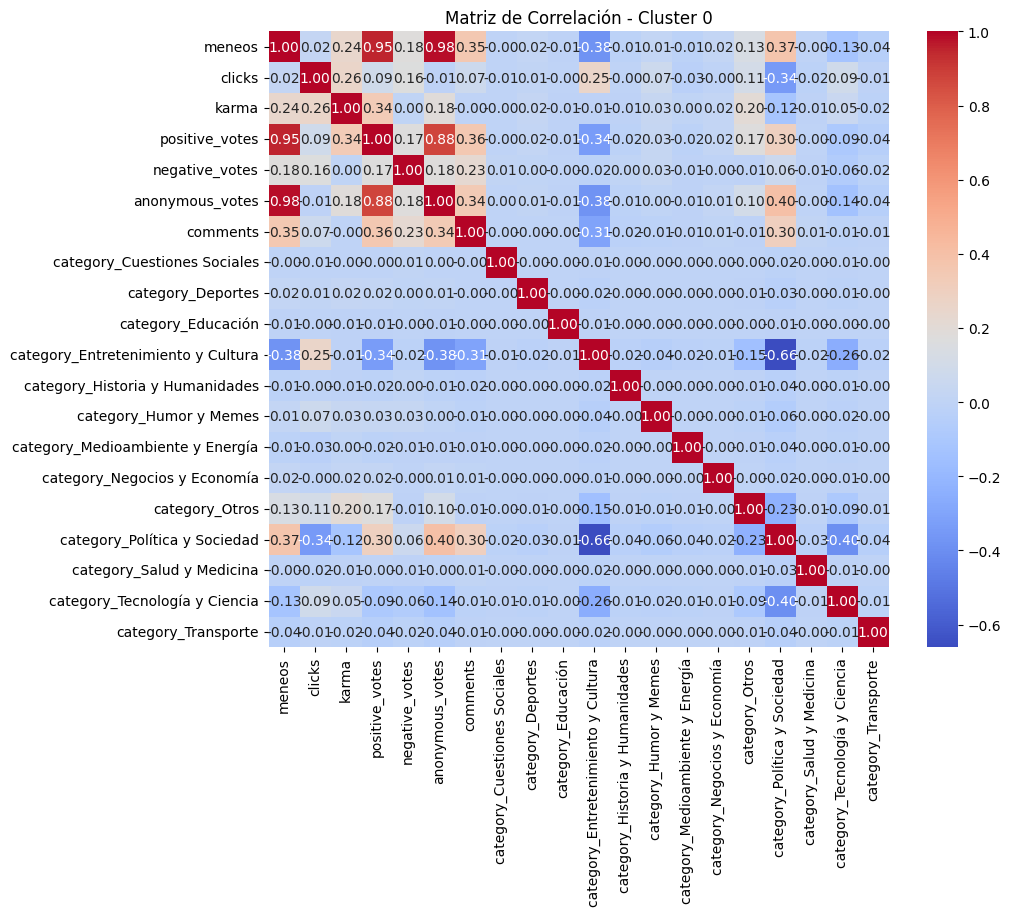

Procesando cluster 1...
(8119, 8)


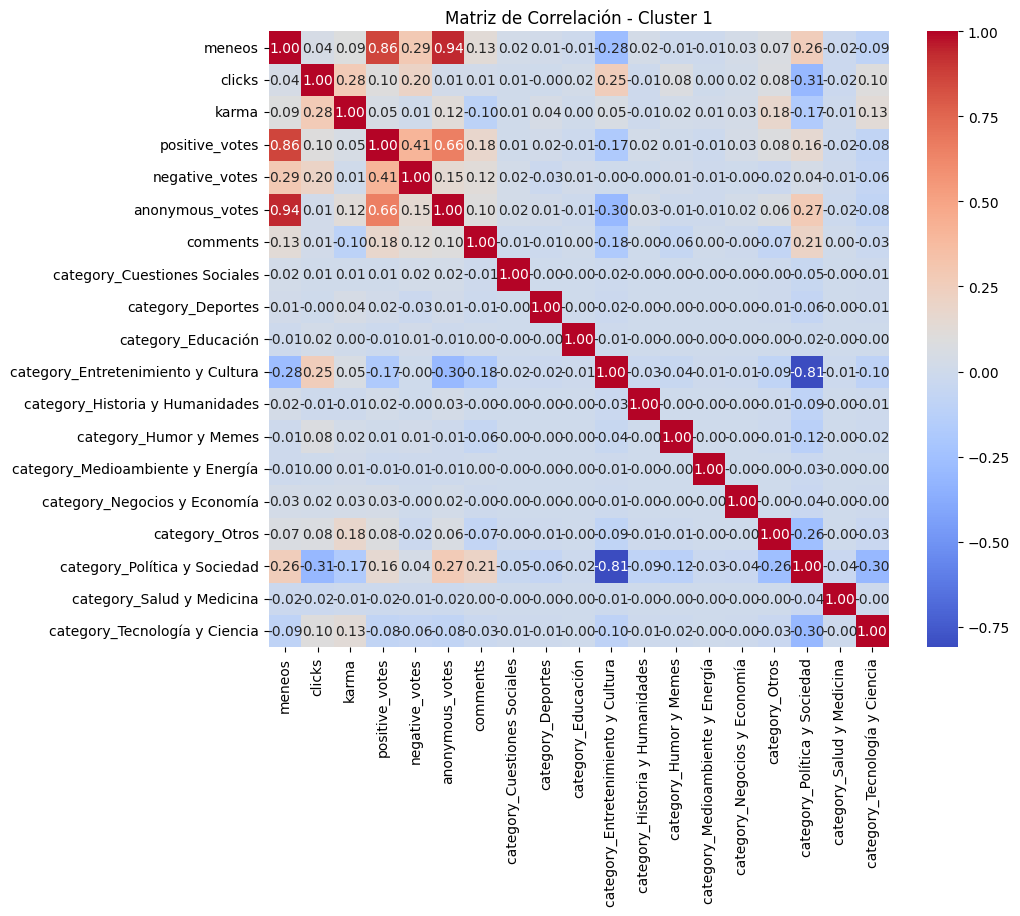

Procesando cluster 2...
(36042, 8)


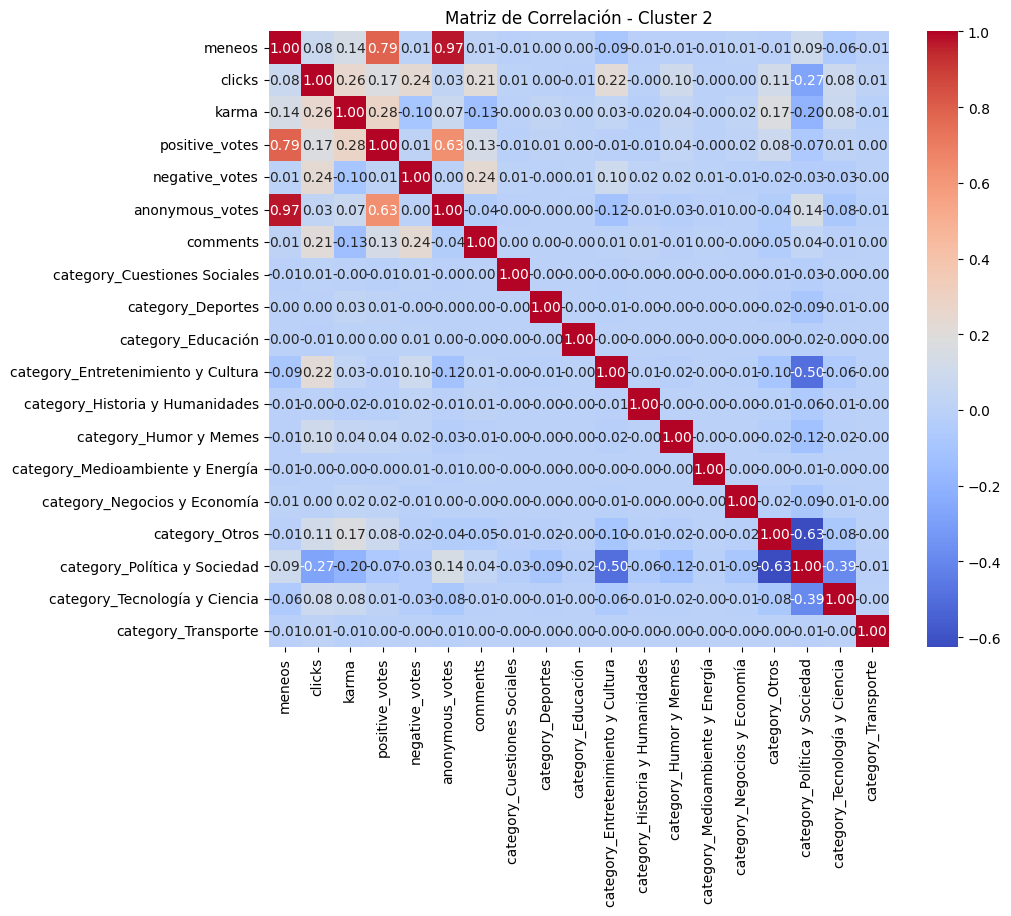

In [7]:
# Definir variables y modelos
num_features = ['meneos', 'karma', 'positive_votes', 'anonymous_votes', 'negative_votes', 'comments']
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Obtener clusters únicos
clusters = df['cluster'].unique()
all_metrics = []

for cluster in clusters:
    print(f'Procesando cluster {cluster}...')
    df_cluster = df[df['cluster'] == cluster].drop(columns=['cluster', 'news_id']).copy()
    print(df_cluster.shape)
    
    df_cluster = remove_outliers_tukey(df_cluster, num_features)
    
    # Aplicar log1p a todas las variables numéricas
    df_cluster[num_features + ['clicks']] = np.log1p(df_cluster[num_features + ['clicks']])
    df_cluster[num_features] = df_cluster[num_features].astype('float32')
    
    # Normalización
    scaler = MinMaxScaler()
    df_cluster[num_features] = scaler.fit_transform(df_cluster[num_features])
    
    # Guardar scaler
    regressor_scaler_path = "../00.data/clustering/regressor_scaler_cluster_{}.pkl".format(cluster)
    with open(regressor_scaler_path, "wb") as f:
        pickle.dump(scaler, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    # OneHotEncoding
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_cats = encoder.fit_transform(df_cluster[['category']])
    encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(['category']))
    
    # Guardar encoder
    regressor_encoder_path = "../00.data/clustering/regressor_encoder_cluster_{}.pkl".format(cluster)
    with open(regressor_encoder_path, "wb") as f:
        pickle.dump(encoder, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    df_cluster.reset_index(drop=True, inplace=True)
    encoded_df.reset_index(drop=True, inplace=True)
    df_cluster = pd.concat([df_cluster, encoded_df], axis=1).drop(columns=['category'])
    
    # Definir X y y
    X = df_cluster.drop(columns=['clicks']).astype('float32')
    y = df_cluster['clicks']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Calcular matriz de correlación
    correlation_matrix = df_cluster.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Matriz de Correlación - Cluster {cluster}')
    plt.show()
    
    best_model = None
    best_medae = float('inf')
    
    # Entrenar y evaluar cada modelo
    for model_name, model in models.items():
        metrics, trained_model = train_and_evaluate_model(X_train, X_test, y_train, y_test, model, model_name)
        metrics['Cluster'] = cluster
        all_metrics.append(metrics)
        
        # Guardar el mejor modelo por cluster basado en Median AE
        if metrics['Median AE'] < best_medae:
            best_medae = metrics['Median AE']
            best_model = trained_model
    
    ml_regression_path = "../00.data/clustering/ml_regression_cluster_{}.pkl".format(cluster)
    with open(ml_regression_path, "wb") as f:
        pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df

,Model,Median AE,MAE,MSLE,R2,Explained Variance,Cluster
0,Linear Regression,1414.101318,2476.128662,0.614748,0.155921,0.224088,0
1,Random Forest,1352.176872,2373.057740,0.589790,0.242299,0.291862,0
2,Gradient Boosting,1329.791855,2384.672007,0.576088,0.209199,0.272008,0
3,Linear Regression,2118.844727,3440.467773,0.556456,0.113759,0.169308,1
4,Random Forest,2141.011413,3373.434325,0.548774,0.168656,0.217067,1
5,Gradient Boosting,2069.233964,3387.120629,0.532900,0.126796,0.182523,1
6,Linear Regression,1471.586060,2568.460205,0.442445,0.150965,0.193583,2
7,Random Forest,1471.340499,2574.146689,0.454865,0.164050,0.199516,2
8,Gradient Boosting,1439.710430,2514.329318,0.428864,0.181061,0.224201,2


In [ ]:
# Parece que el mejor modelo independientemente de cluster al que pertenezca es Gradient Boosting
# Cluster 1 (polémicas) tiene las peores métricas, seguramente porque es el cluster con mayor variabilidad de clicks
# al tener r2 y explained variance bajos, los modelos explican menos la variabilidad de los datos
